# Biodiversity Intactness Index change in Phoenix subdivision
Author: Patricia Park
Github repository can be access here: https://github.com/p-park6/biodiversity-index-phoenix


# Preliminary information
This notebook covers the biodiversity intactness index (BII), specifically in Maricopa County, which is in the Phoenix metropolitan area. Over 270 square miles have been converted into developed land since 2001 [^1]. One potential impact that increased urban sprawl has is how it is impacting the biodiversity and natural areas. This notebook will be looking at the potential impacts increased developed land has on the BII.


## Notebook Highlights
- Fetching data from the Microsoft Planetary Computer STAC catalog
- Creating an overlay of Phoenix county on a basemap
- Calculating percentage of area with a BII of over 0.75
- Creating a visualization of lost BII over 0.75 from 2017 to 2020


## Datasets information

### Dataset 1
The first dataset that I will be using is from the Microsoft Planetary Computer STAC API, which houses the needed geospatial data we will use in this notebook. This dataset houses multiple data catalog ranging from air quality to infrastructure. For this notebook, we will be looking at the [Biodiversity Intactness data catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview), which is compiled from 32,000 sites from over 750 studies.

### Dataset 2
The second dataset that I will be using is a [TIGER shapefile](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions) from Arizona. The Phoenix county polygon was obtained by subsetting the Arizona shapefile for `Phoenix`. [^3]


[^1]: Levitt, Z., & Eng, J. (2021, August 11). Where America’s developed areas are growing: ‘Way off into the horizon.’ Washington Post. https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/

[^2]: Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. https://doi.org/10.5281/zenodo.7261897

[^3]: United States Census Bureau. (2022).

## Final Outputs
This notebook will show an output of the overlay of Phoenix county over a basemap and an output of a visualization of BII over or equal to 0.75 highlighting where there was a loss of BII from 2017 to 2020.

![](images/phoenix_county.png)


![](images/bii_phoenix.png)

### Import libraries
We will first import all the necessary libraries in order to do our analysis and our mapping.

In [1]:
#import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import os
import numpy as np
import rioxarray as rioxr


import pystac_client
import planetary_computer
import contextily as ctx 

import rasterio

from shapely.geometry import Polygon

from IPython.display import Image

### Data Organizing

Before we can do any analysis, we need to reorganize our data to the information we are looking. 

#### MPC STAC catalog
First, let's go ahead and organize the STAC data from the catalog.

In [2]:
#read in all data:
#read in data from catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
#read in Arizona shapefile
arizona = gpd.read_file(os.path.join('data', 'tl_2022_04_cousub.shp'))

In [3]:
# specify temporal range of interest
time_range = "2017/2020"

# specify what collection to search from as well as the bounding box and the date range
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574],
    datetime = time_range)

#narrow the search down to the item collection
items = search.item_collection()

#subset for the first item for 2020
item_2020 = items[0]
#subset for the first item for 2017
item_2017 = items[3]

4

We've sucessfully filtered for each year and created each year as its own item

#### Phoenix polygon
Let's go ahead and filter for the Phoenix polygon from the Arizona shapefile. We should first see what is contained in this dataset.

In [7]:
#view the first 5 entries in the arizona dataset
#arizona.head()

#make column names lowercase
arizona.columns = arizona.columns.str.lower()

#find the unique names in the name column
arizona.name.unique()

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Sweetwater', 'Fort Defiance', 'Dennehotso', 'Puerco',
       'Ash Fork', 'Cordes Lakes-Mayer', 'Camp Verde-Sedona', 'Prescott',
       'Piñon', 'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin',
       'Gila River', 'Casa Grande', 'Maricopa-Stanfield',
       "Tohono O'odham Nation", 'Coolidge', 'Ajo', 'Marana', 'Somerton',
       'Bonita-Klondyke', 'Eagar-Springerville', 'San Carlos',
       'Havasupai', 'William

<Axes: >

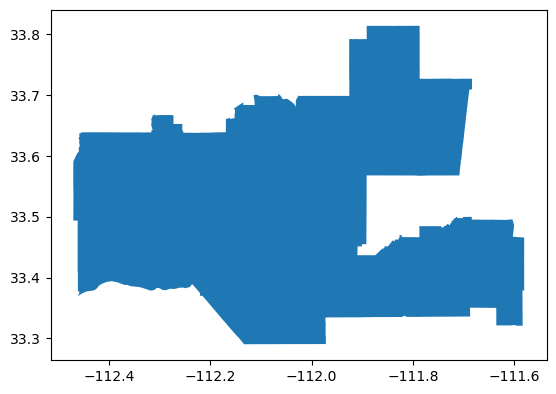

In [8]:
#subset for just rows that relate to Phoenix data
phoenix = arizona[arizona['name'] == 'Phoenix']
#plot the subsetted dataset to see if Phoenix was sucessfully filtered out
phoenix.plot()

### Phoenix subdivision map

Now that we have filtered for the data we want, let's map out Phoenix on top of a map to visually see how much area it spans.

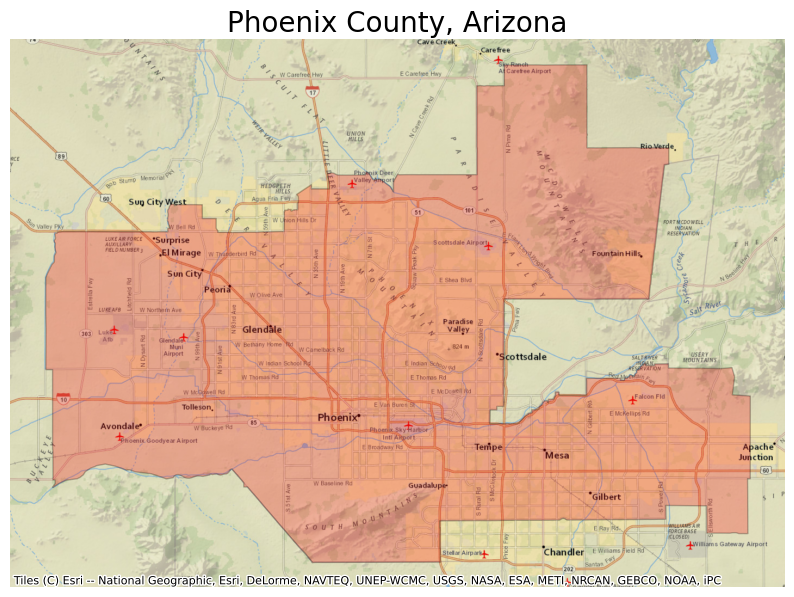

In [9]:
#create a map with Phoenix outline on top
# create axis with plot
ax = (phoenix.to_crs(epsg=3857)
      .plot(figsize=(10, 10), 
            alpha=0.25, 
            edgecolor="k",
            color = "red")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix County, Arizona", fontdict={"fontsize": "20"})
ax.set_axis_off()

#save map into image folder
plt.savefig('images/phoenix_county.png', bbox_inches='tight',  dpi=100)

We can see above that almost all of Phoenix county is in developed land. 

### Percentage of BII above .75
Since we are interested in seeing how the BII has changed over the years, let's go ahead and calculate the BII for the years we are interested in. 

*Note*: I have commented out the self checks that have helped me visualize what I have done. I encourage you to uncomment them to also see the output of each code.

In [10]:
#Percentage of BII over 0.75 for 2017:
#create into raster by filtering to the raster asset
phoenix_raster_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
#phoenix_raster_2017

#reproject phoenix crs to phoenix raster crs
phoenix = phoenix.to_crs(phoenix_raster_2020.rio.crs)
#print(phoenix.crs == phoenix_raster_2020.rio.crs)

#clip raster to Phoenix county
phoenix_raster_2017 = phoenix_raster_2017.rio.clip(phoenix['geometry'])
#phoenix_raster_2017.plot()

#find BII that are above 0.75
phoenix_75_2017 = (phoenix_raster_2017 >= .75)
#convert true and false into boolean
phoenix_75_2017_int = phoenix_75_2017.astype(int)
#phoenix_75_2017_int.plot()

#find the count and sum to be able to find the percentage:
#count
count_phoenix_2017 = phoenix_75_2017_int.count()
#print(count_phoenix_2017)
#sum
sum_phoenix_2017 = phoenix_75_2017_int.sum()
#print(sum_phoenix_2017)

#find percentage of BII over 0.75
phoenix_percentage_2017 = (sum_phoenix_2017/count_phoenix_2017)*100
print(phoenix_percentage_2017)

NameError: name 'phoenix_raster_2020' is not defined

In [ ]:
#Percentage of BII over 0.75 for 2020:
#create into raster by filtering to the raster asset
phoenix_raster_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
#phoenix_raster_2020

#clip raster to Phoenix polygon
phoenix_raster_2020 = phoenix_raster_2020.rio.clip(phoenix['geometry'])
#phoenix_raster_2020.plot()

#find BII that are above 0.75
phoenix_75_2020 = (phoenix_raster_2020 >= .75)
#convert true and false into boolean
phoenix_75_2020_int = phoenix_75_2020.astype(int)
#phoenix_75_2020_int.plot()

#find the count and sum to be able to find the percentage:
#count
count_phoenix_2020 = phoenix_75_2020_int.count()
#print(count_phoenix_2020)
#sum
sum_phoenix_2020 = phoenix_75_2020_int.sum()
#print(sum_phoenix_2020)

#find percentage of BII over 0.75
phoenix_percentage_2020 = (sum_phoenix_2020/count_phoenix_2020)*100
print(phoenix_percentage_2020)

### BII greater than or equal to .75 visualization

We've found the BII over 0.75 for the year 2017 and 2020. Let's go ahead and create a visualization of Phoenix BII for 2020, highlighting the places where there was a loss in BII from 2017 to 2020.

In [ ]:
#find the loss in BII
phoenix_difference = phoenix_75_2017_int - phoenix_75_2020_int
#have phoenix_difference equal to 1 to mask correctly
phoenix_difference = phoenix_difference == 1
#convert phoenix difference array to a boolean
phoenix_difference = phoenix_difference.astype(int)

In [ ]:
# create a customized mask of loss in BII:
#pick color to highlight loss in BII
colors = ['none', 'red']
#create a variable using color list from above
cmap = plt.cm.colors.ListedColormap(colors)
#combine to add variables to the new mask
phoenix_difference.plot(cmap=cmap, add_colorbar = False)

In [ ]:
#create map of BII:

#--------------Create empty map-------------------#
#create basemap
fig, ax = plt.subplots(figsize = (6,3))
#turn axis off
ax.axis('off')


#------------Plot cropped phoenix raster 2020--------------#
phoenix_raster_2020.plot(ax = ax, 
                          cmap = "Greens",
                        add_colorbar = False) ##HOW DO I ADD LABEL FOR SCALE ON THE SIDE


#-------------Plot phoenix lost of BII--------------------#
phoenix_difference.plot(cmap=cmap, add_colorbar = False)
phoenix_difference_patch = mpatches.Patch(color='red',
                              label='Area where BII ≥ 75% with loss from 2017 to 2020')


#-------------Plot phoenix polygon to get black edge-------------#
phoenix.plot(ax = ax, color = 'none', edgecolor = 'black', linewidth = 2)


#--------------Customize map------------------------#
#add title
ax.set_title("Biodiversity Intactness Index (BII), Phoenix Area")
#add legend for patch
ax.legend(handles = [phoenix_difference_patch], frameon=False, loc='lower left', bbox_to_anchor= (0, -0.2))

#save map into image folder
plt.savefig('images/bii_phoenix.png', bbox_inches='tight',  dpi=100)

#show plot
plt.show()